# TITANIC - Regresión Logística

Vamos a crear un modelo de Regresión Logística que nos ayude a predecir la probabilidad de supervivencia de los pasajeros del Titanic.

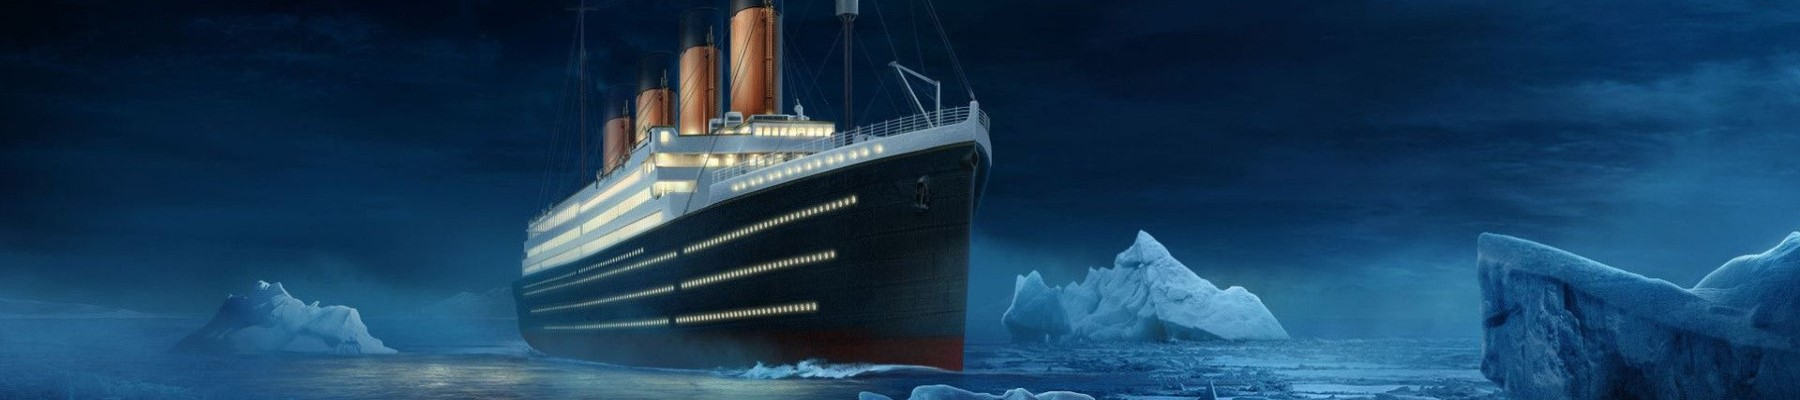

Los datos están disponibles en:  
https://www.kaggle.com/c/titanic/data?select=train.csv

Las librerías que vamos a utilizar son las siguientes:

In [252]:
# Cargar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

### 1. Importar datos

Lo primero que vamos a hacer es traer los archivos necesarios para el análisis:

In [255]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
submission = pd.read_csv("gender_submission.csv")

Una vez importados los archivos, vamos a unir la columna de "survived" al archivo de test para tener disponible esa columna en el análisis:

In [257]:
# Comprobamos dimensión inicial de test
test.shape

(418, 11)

In [258]:
# Unimos la columna de "survived"
test = test.merge(submission, how="left")

In [259]:
# Comprobamos dimensión tras la unión
test.shape

(418, 12)

### 2. Tratamiento de nulos

En este apartado nos vamos a centrar en el tratamiento de los datos nulos. Por un lado, vamos a comprobar qué datos nulos trae el dataset y por otro, veremos qué criterios seguir para completarlos (o eliminar la columna).

#### Comprobar nulos

Los nulos que contiene el archivo de ***test*** son:

In [264]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived         0
dtype: int64

In [265]:
total_nulos_test = test.shape[0]
print(f"La columna Age tiene un {round(86/total_nulos_test*100, 2)}%")
print(f"La columna Cabin tiene un {round(327/total_nulos_test*100, 2)}%")
print(f"La columna Fare tiene un {round(1/total_nulos_test*100, 2)}%")

La columna Age tiene un 20.57%
La columna Cabin tiene un 78.23%
La columna Fare tiene un 0.24%


Los nulos que contiene el archivo ***train*** son:

In [267]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [268]:
total_nulos_train = train.shape[0]
print(f"La columna Age tiene un {round(177/total_nulos_train*100, 2)}%")
print(f"La columna Cabin tiene un {round(687/total_nulos_train*100, 2)}%")
print(f"La columna Embarked tiene un {round(2/total_nulos_train*100, 2)}%")

La columna Age tiene un 19.87%
La columna Cabin tiene un 77.1%
La columna Embarked tiene un 0.22%


#### Completar nulos

Vamos a ***eliminar la columna de Cabin*** en ambos archivos puesto tiene demasiados datos nulos:

In [271]:
# Eliminar la columna Cabin
test.drop("Cabin", axis="columns", inplace=True)
train.drop("Cabin", axis="columns", inplace=True)

Ahora toca ***completar lo datos faltantes*** en las columnas de ***Age*** y ***Embarked***. Vamos a graficar ambas variables para que nos ayude a tomar una mejor decisión.

##### Age

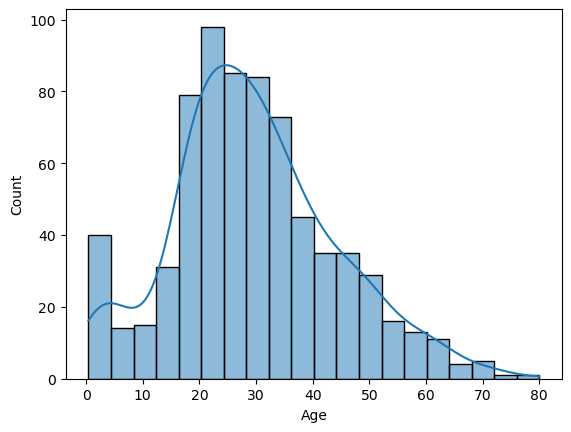

In [274]:
# Visualizar distribución
sns.histplot(train["Age"], kde=True)
plt.show()

Como vemos, la variable "Age" sigue una distribución normal, por lo que un buen criterio en este caso podría ser completar los valores faltantes con la ***mediana***.

In [276]:
# Completar datos con la mediana
test["Age"] = test["Age"].fillna(test["Age"].median())

train["Age"] = train["Age"].fillna(train["Age"].median())

##### Embarked

In [278]:
embarked = train.groupby("Embarked").agg({"PassengerId" : "count"}).reset_index()

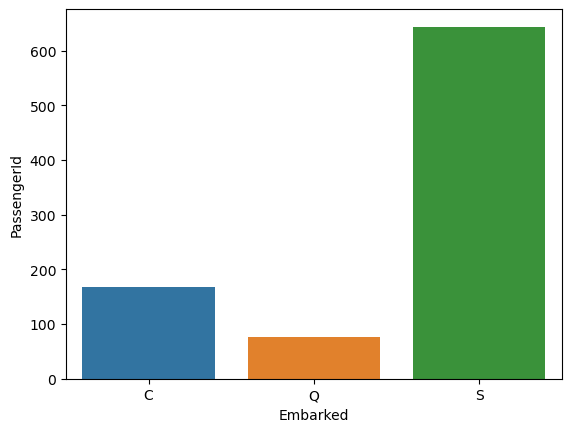

In [279]:
sns.barplot(x=embarked["Embarked"], y=embarked["PassengerId"], hue = embarked["Embarked"])
plt.show()

En este caso, al ser valores discretos y haber uno de ellos con mayor frecuencia, un buen criterio podría ser rellenar los valores faltantes con la ***moda***.

In [281]:
train["Embarked"] = train["Embarked"].fillna(train["Embarked"].mode()[0])

##### Fare

En este caso, al tratarse de un sólo valor el que falta, vamos a realizar el tratamiento de forma manual.

In [284]:
# Localizar el dato faltante
test.loc[test["Fare"].isnull(), :]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,0


Vemos que se trata de un pasajero de tercera clase, por lo que vamos a completar el valor faltante de "Fare" con el precio promedio de la tercera clase:

In [286]:
# Calculamos el precio promedio
promedio = test.loc[test["Pclass"] == 3, "Fare"].mean()

In [287]:
# Completamos el valor faltante con el promedio
test["Fare"] = test["Fare"].fillna(promedio)

### Otras variables: Pclass, Sex y Fare

Vamos a visualizar cómo sobrevivieron las personas en base a la clase, sexo y coste del billete.

##### Pclass

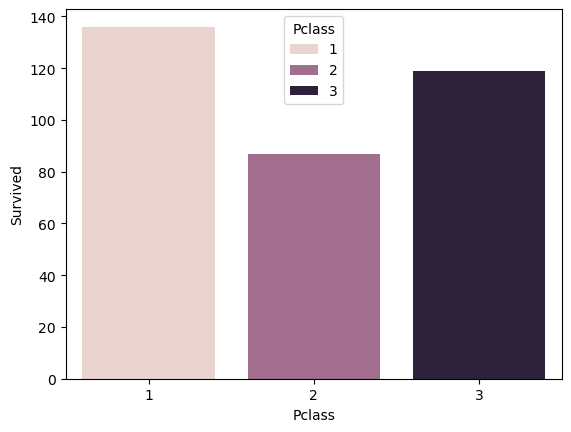

In [291]:
data_pclass = train.groupby("Pclass").agg({"Survived" : "sum"}).reset_index()
sns.barplot(x=data_pclass["Pclass"], y=data_pclass["Survived"], hue=data_pclass["Pclass"])
plt.show()

Como vemos, la mayor parte de los pasajeros que sobrevivieron corresponden a la primera clase, mientras que la clase en la que menos pasajeros sobrevivieron fue en la segunda.

##### Sex

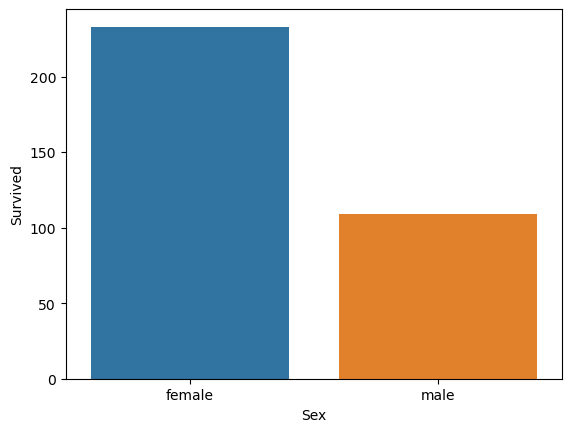

In [294]:
data_sex = train.groupby("Sex").agg({"Survived" : "sum"}).reset_index()
sns.barplot(x=data_sex["Sex"], y=data_sex["Survived"], hue=data_sex["Sex"])
plt.show()

En el caso de la variable "Sex" vemos como la gran parte de los pasajeros supervivientes son mujeres, siendo más del doble respecto al de los hombres.

##### Fare

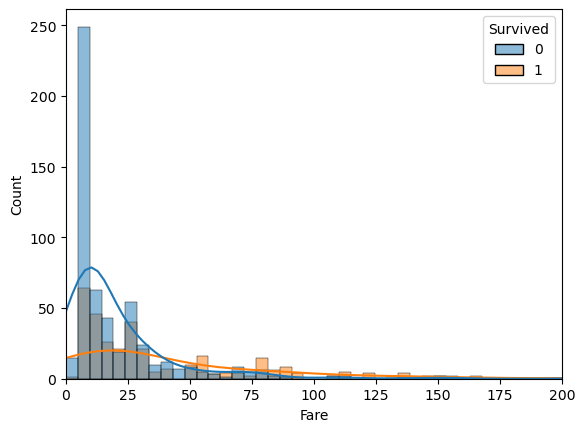

In [297]:
sns.histplot(x=train["Fare"], hue=train["Survived"], kde=True)
plt.xlim((0, 200))
plt.show()

En este caso vemos como la mayor parte de los pasajeros no sobrevive, pero a medida que el billete es más costoso la tasa de supervivencia aumenta.

### Generar dummies

Como acabamos de ver, las últimas tres variables analizadas tienen relación con la tasa de supervivencia. Vamos a generar columnas dummies para identificar mejor qué valor afecta más.

In [301]:
# Generar dummies en train
train = pd.get_dummies(
    train,
    columns=["Pclass", "Embarked", "Sex"],
    drop_first=True
)

In [302]:
# Generar dummies en test
test = pd.get_dummies(
    test,
    columns=["Pclass", "Embarked", "Sex"],
    drop_first=True
)

### Eliminar columnas

En este apartado vamos a eliminar en ambos archivos las columnas que consideramos que no aportan significativamente al modelo. Dichas columnas son *"PassengerId", "Name" y "Ticket"*.

In [305]:
# Eliminamos columnas de train
train.drop('PassengerId', axis=1, inplace=True)
train.drop('Name', axis=1, inplace=True)
train.drop('Ticket', axis=1, inplace=True)

# Eliminamos columnas de test
test.drop('PassengerId', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)
test.drop('Ticket', axis=1, inplace=True)

 ### Agregar columna "IsMinor"

Vamos a crear una nueva columna que se llame "IsMinor" que muestre 1 en caso de tener una edad igual o inferior a 17 años y 0 en caso contrario.

In [308]:
# Crear columna en train
train["IsMinor"] = np.where(train["Age"] <=17, 1, 0)

# Crear columna en test
test["IsMinor"] = np.where(test["Age"] <=17, 1, 0)

## CREAR EL MODELO

Una vez tenemos el dataset con la información que queremos, ya podemos proceder a crear y ajustar el modelo:

In [311]:
# Crear variables X_train e y_train
X_train = train.loc[:, train.columns != "Survived"]
y_train = train["Survived"]

# Crear el modelo
modelo = LogisticRegression(max_iter=1000000)

# Entrenar el modelo
modelo.fit(X_train, y_train)

LogisticRegression(max_iter=1000000)

Ahora que ya tenemos el modelo creado y entrenado, vamos a validarlo con los datos de test:

In [313]:
# Crear X_test e y_real
X_test = test.loc[:, test.columns != "Survived"]
y_real = test["Survived"]

# Crear columnas de predicción
test["y_pred"] = modelo.predict(X_test)
test["y_pred_proba"] = modelo.predict_proba(X_test)[:, 1]

Ahora ya tenemos en test una columna con la predicción del modelo ("y_pred") y otra con la probabilidad de la predicción ("y_pred_prob").

#### Matriz de confusión

Ahora podemos calcular la matriz de confusión, que nos ayudará a evaluar qué tan bueno es nuestro modelo.

In [317]:
matriz_confusion = confusion_matrix(test["Survived"], test["y_pred"])
matriz_confusion

array([[251,  15],
       [ 16, 136]], dtype=int64)

Otra forma de verla es de la siguiente manera:

In [319]:
test.groupby(["y_pred", "Survived"]).size()

y_pred  Survived
0       0           251
        1            16
1       0            15
        1           136
dtype: int64

#### Accuracy

El accuracy (precisión) es la proporción de predicciones correctas sobre el total de predicciones realizadas por el modelo.

In [322]:
(matriz_confusion[0][0] + matriz_confusion[1][1]) / matriz_confusion.sum()

0.9258373205741627

#### Recall

El recall (sensibilidad) es la proporción de casos positivos que fueron correctamente identificados por el modelo.

In [325]:
(matriz_confusion[1][1])/(matriz_confusion[1][1] + matriz_confusion[1][0])

0.8947368421052632

#### True Negative Rate

El True Negative Rate (especificidad) es la proporción de casos negativos que fueron correctamente identificados por el modelo.

In [328]:
(matriz_confusion[0][0])/(matriz_confusion[0][0] + matriz_confusion[0][1])

0.943609022556391

#### Curva de ROC

La curva de ROC confronta el ratio de falsos positivos con el ratio de verdaderos positivos.

In [331]:
especificidad_inv, sensibilidad, threshold = roc_curve(test["Survived"], test["y_pred_proba"])

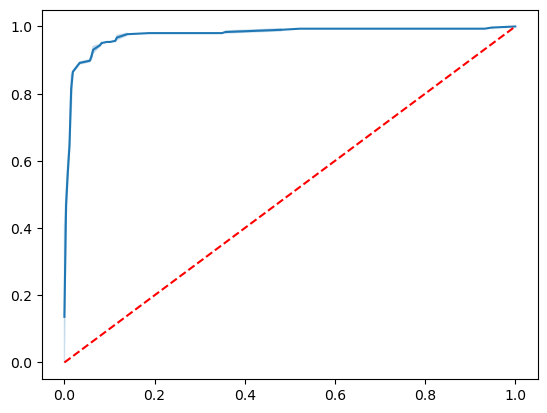

In [332]:
# Crear rectas
recta_x = [i * 0.01 for i in range(101)]
recta_y = recta_x

# Graficar valores
sns.lineplot(x = especificidad_inv, y = sensibilidad)
sns.lineplot(x = recta_x, y = recta_y, ls = "--", c = "r")
plt.show()

Cuanto más se aproxime a 1 el área bajo la curva de ROC más perfecto será el modelo, ya que 1 sería predecir un 100% de verdaderos positivos y el 0% de falsos positivos.  
Podemos calcularlo de la siguiente manera:

In [334]:
# Calcular área bajo la curva
roc_auc_score(test["Survived"], test["y_pred_proba"])

0.9757865057380293